In [25]:
''' 
This script takes an arbitrary combination of materials, demand scenarios, sources, and price/quantity
breaks and calculates economic order quantities for each scenario. It calculates not just the value
from the specified parameters, but also generates normal distributions (standard deviation defaults
to 20% of the value) around the order fixed cost and unit carrying cost. This enables the calculation of a
95% confidence interval around the estimate, given the uncertainty around the precision of both numbers.

The JSON structure is described below. The private version of this included Excel import/export.

Note that the calculation routine will sometimes generate warnings about invalid values in the sqrt 
calculation. Since we're working with normally distributed variables, occasionally a random number 
(or combination of random numbers) will be generated that makes the value being square rooted negative.
This is nothing to worry about, these values will become NaN and be discarded.
'''

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
CoC = .15

In [26]:
demand = [5000,
         10000]

mats = {}
mats['material'] = {}
mats['material']['_Demand'] = demand
mats['material']['_Sources'] = {}
mats['material']['_Sources']['source'] = {}
#mats['material']['_Sources']['source']['_CarryCost'] = 10
mats['material']['_Sources']['source']['_FixedCost'] = 10
mats['material']['_Sources']['source']['_CurrentOrdQty'] = 100
mats['material']['_Sources']['source']['_Prices'] = {}
mats['material']['_Sources']['source']['_Prices'][1] = 15

In [27]:
EOQ_sim_stop = 2

def EOQ_mc(D, K, h, n=1000, K_sd=.2, h_sd=.2):
    K_mc = np.random.normal(K, K * K_sd, n)
    h_mc = np.random.normal(h, h * h_sd, n)
    Qstar_mc = np.sqrt(2 * D * K_mc / h_mc)
    Qstar_mc_oh = (D/Qstar_mc * K + Qstar_mc*h_mc/2)
    return Qstar_mc, Qstar_mc_oh
    

def EOQ_sim(D, K, h, stop=EOQ_sim_stop, start=1):
    EOQ = np.round(np.sqrt(2 * D * K / h))
    
    q = np.arange(start, EOQ*stop)
    cost_fixed = D * K / q 
    cost_carry = (h * q) / 2

    return q, cost_fixed, cost_carry, EOQ

def EstCurrOH(D, K, h, q):
    cost_fixed = D * K / q
    cost_carry = (h * q)/2
    currOH = cost_fixed + cost_carry
    return(currOH)


In [28]:
for m in mats.keys():
    mats[m]['Analysis'] = {}
    for source in mats[m]['_Sources'].keys():
        mats[m]['Analysis'][source] = {}
    
        if '_Prices' in mats[m]['_Sources'][source].keys():
            for qty_break in mats[m]['_Sources'][source]['_Prices'].keys():
                mats[m]['Analysis'][source][qty_break] = {}


                for d_qty in mats[m]['_Demand']:
                    try:
                        CarryCost = mats[m]['_Sources'][source]['_CarryCost']
                    except:
                        CarryCost = mats[m]['_Sources'][source]['_Prices'][qty_break] * CoC
                    

                    
                    mats[m]['Analysis'][source][qty_break][d_qty] = {}
                    mats[m]['Analysis'][source][qty_break][d_qty]['Quantity'], \
                    mats[m]['Analysis'][source][qty_break][d_qty]['FixedCost'], \
                    mats[m]['Analysis'][source][qty_break][d_qty]['CarryCost'], \
                    mats[m]['Analysis'][source][qty_break][d_qty]['EOQ'] \
                    = EOQ_sim(d_qty,
                              mats[m]['_Sources'][source]['_FixedCost'],
                              CarryCost,                                                                                         
                    )
                    mats[m]['Analysis'][source][qty_break][d_qty]['OHCost'] = \
                    mats[m]['Analysis'][source][qty_break][d_qty]['CarryCost'] + \
                    mats[m]['Analysis'][source][qty_break][d_qty]['FixedCost']
                    
                    mats[m]['Analysis'][source][qty_break][d_qty]['MC'] = {}
                    mats[m]['Analysis'][source][qty_break][d_qty]['MC']['Qstar'], \
                    mats[m]['Analysis'][source][qty_break][d_qty]['MC']['Qstar_OH'] \
                    = EOQ_mc(d_qty,
                             mats[m]['_Sources'][source]['_FixedCost'],
                             CarryCost, 
                            )
                    
                    
                    try:
                        
                        CurrOrdQty = mats[m]['_Sources'][source]['_CurrentOrdQty']
                        mats[m]['Analysis'][source][qty_break][d_qty]['EstCurrOH'] \
                        = EstCurrOH(d_qty,
                                    mats[m]['_Sources'][source]['_FixedCost'],
                                    CarryCost,
                                    CurrOrdQty
                                   )
                    except:
                        pass
                    
                    mats[m]['Analysis'][source][qty_break][d_qty]['MC']['CI'] = np.nanpercentile(
                        mats[m]['Analysis'][source][qty_break][d_qty]['MC']['Qstar'], (2.5, 97.5)
                    )
                    

  

In [29]:
def plotEOQ(mat, source, demand, qtybreak, figsize=(8,8)):
    

    
    legend = ('Total cost (ex. unit cost)', 'Carrying cost', 'Order cost', 'EOQ', '95% Confidence Interval')
    try:
        currOH = mats[mat]['Analysis'][source][qtybreak][demand]['EstCurrOH']
        legend = ('Total cost (ex. unit cost)', 'Carrying cost', 'Order cost', 'EOQ', '95% Confidence Interval',
                  'Simulated with variance', 'Current Order Qty', )
        opp = currOH - round(min(mats[mat]['Analysis'][source][qtybreak][demand]['OHCost']))
    except:
        currOH = -1
        

        
    ylim = max([min(mats[mat]['Analysis'][source][qtybreak][demand]['OHCost']), currOH])
    fig = plt.figure()

    plt.figure(figsize=figsize)
    titlestr = "Material: " + str(mat) + ", Demand: " + str(demand) + ", Qty Break: " + str(qtybreak)

    plt.ylim(0, ylim*1.5)

    plt.plot(mats[mat]['Analysis'][source][qtybreak][demand]['Quantity'],
             mats[mat]['Analysis'][source][qtybreak][demand]['OHCost'], 'b')

    plt.plot(mats[mat]['Analysis'][source][qtybreak][demand]['Quantity'],
             mats[mat]['Analysis'][source][qtybreak][demand]['CarryCost'], 'c:')

    plt.plot(mats[mat]['Analysis'][source][qtybreak][demand]['Quantity'],
             mats[mat]['Analysis'][source][qtybreak][demand]['FixedCost'], 'g:')
    
    plt.scatter(mats[mat]['Analysis'][source][qtybreak][demand]['MC']['Qstar'],
                mats[mat]['Analysis'][source][qtybreak][demand]['MC']['Qstar_OH'], c='k', alpha=.2)
    
    
    
    plt.axvline(x=mats[mat]['Analysis'][source][qtybreak][demand]['EOQ'], c='r', linestyle='dashed')
    
    CI = mats[mat]['Analysis'][source][qtybreak][demand]['MC']['CI']
    plt.axvspan(CI[0], CI[1], alpha=.1, color='b')
    
    xloc = max(mats[mat]['Analysis'][source][qtybreak][demand]['Quantity'])*.025
    
    if currOH >= 0:
        CurrOrdQty = mats[mat]['_Sources'][source]['_CurrentOrdQty']
        #plt.axhline(y=currOH, c='k', ls='-.', alpha=.25)
        plt.scatter(CurrOrdQty, currOH, s=100, c='r')
        plt.annotate('Opportunity: '+str(round(opp)), xy=(xloc,ylim*.25))

    plt.annotate('Min OH Cost: ' + str(round(min(mats[mat]['Analysis'][source][qtybreak][demand]['OHCost']))), 
                 xy=(xloc,ylim*.3))
    
    plt.annotate('95% Conf. Interval: ' + str(round(CI[0])) + " - " + str(round(CI[1])),
                xy=(xloc, ylim*.2))
    
    plt.annotate('EOQ: ' + str(mats[mat]['Analysis'][source][qtybreak][demand]['EOQ']),
                xy=(mats[mat]['Analysis'][source][qtybreak][demand]['EOQ']*1.03, ylim*.05))
    
    
    try:
        CarryCost = mats[mat]['_Sources'][source]['_CarryCost']
    except:
        CarryCost = -1
    
    if CarryCost > 0:
        plt.annotate('Manual Unit Carrying Cost Assumption: ' + str(CarryCost),
                    xy=(xloc, ylim*.15))
    else:
        plt.annotate('Default Carrying Cost (Marginal cost * 15% CoC)',
                    xy=(xloc, ylim*.15))

    
    plt.ylabel('Fixed Order Cost + Carrying cost')
    plt.xlabel('Order Qty')
    plt.title(titlestr)
    plt.legend(legend)
    plt.savefig('eoqplot.png')

    plt.show()

<Figure size 432x288 with 0 Axes>

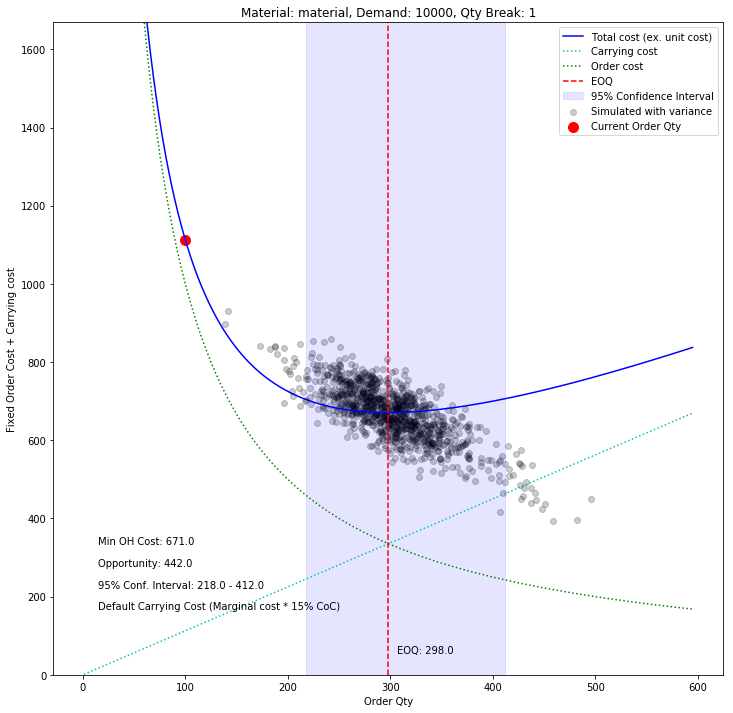

In [30]:
figsize=(12,12)
mat = 'material'
source = 'source'
demand = 10000
qtybreak = 1

plotEOQ(mat, source, demand, qtybreak, figsize)